# Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
%matplotlib inline  

# Reading Datasets

In [2]:
source = 'input/'
df = {'ar':pd.read_csv(source+'air_reserve.csv'),
        'ar_i':pd.read_csv(source+'air_store_info_modif.csv'),
        'train':pd.read_csv(source+'air_visit_data_with_weather.csv'),
        'date_info':pd.read_csv(source+'date_info.csv'),
        'hr':pd.read_csv(source+'hpg_reserve.csv'),
        'hr_i':pd.read_csv(source+'hpg_store_info.csv'),
        'test':pd.read_csv(source+'sample_submission_with_weather.csv'),
        'rel':pd.read_csv(source+'store_id_relation.csv')}

In [3]:
df['date_info'].loc[((df['date_info'].day_of_week=='Saturday') | (df['date_info'].day_of_week=='Sunday'))&(df['date_info'].free_period==0),'free_period']=2

In [4]:
df['test']['visit_date'] = df['test']['id'].map(lambda x: str(x).split('_')[2])
df['test']['air_store_id'] = df['test']['id'].map(lambda x: '_'.join(x.split('_')[:2]))

In [5]:
df['hr']=df['hr'].join(df['rel'].set_index('hpg_store_id'), on = 'hpg_store_id').dropna(how='any')
df['hr_i']=df['hr_i'].join(df['rel'].set_index('hpg_store_id'), on = 'hpg_store_id').dropna(how='any')

df['hr'] = df['hr'].drop('hpg_store_id',axis=1)
df['hr']=df['hr'].set_index('air_store_id').reset_index()

df['hr_i'] = df['hr_i'].drop('hpg_store_id',axis=1)
df['hr_i']=df['hr_i'].set_index('air_store_id').reset_index()

# Working with Dates 

df['date_info']['golden_week']=0

df['date_info'].loc[( (pd.to_datetime(df['date_info']['calendar_date'])>pd.to_datetime('2016-04-28')) & (pd.to_datetime(df['date_info']['calendar_date'])<pd.to_datetime('2016-05-06')) ),'golden_week']=1
df['date_info'].loc[( (pd.to_datetime(df['date_info']['calendar_date'])>pd.to_datetime('2017-04-28')) & (pd.to_datetime(df['date_info']['calendar_date'])<pd.to_datetime('2017-05-06')) ),'golden_week']=1

In [6]:
for name in ['ar','hr']:
        
    df[name]['visit_datetime'] = pd.to_datetime(df[name]['visit_datetime'])
    df[name]['reserve_datetime'] = pd.to_datetime(df[name]['reserve_datetime'])
    df[name]['visit_date'] = df[name].visit_datetime.dt.date
    df[name]['visit_time'] = df[name].visit_datetime.dt.hour
    
    df[name]['prior'] = df[name]['visit_datetime'] - df[name]['reserve_datetime']
    df[name]['prior'] = df[name].prior/np.timedelta64(1, 'D')

    df[name]['dow'] = df[name].visit_datetime.dt.dayofweek
    df[name]['month'] = df[name].visit_datetime.dt.month
    df[name]['year'] = df[name].visit_datetime.dt.year

In [7]:
for name in ['test','train']:
    df[name]=df[name].join(df['date_info'][['calendar_date','holiday_flg','free_period']].rename(columns={'calendar_date':'visit_date'}).set_index('visit_date'),on='visit_date')
    df[name]['visit_date'] = pd.to_datetime(df[name]['visit_date'])

    df[name]['dow'] = df[name].visit_date.dt.dayofweek
    df[name]['month'] = df[name].visit_date.dt.month
    df[name]['quarter'] = df[name].visit_date.dt.quarter
    df[name]['year'] = df[name].visit_date.dt.year

In [8]:
df['ar']['ar']=1
df['hr']['ar']=0

# Reserver's behaviour

Understanding each restaurant's visitors' reserving behaviour

In [9]:
df['all_res']=pd.concat([df['ar'],df['hr']],axis=0)

In [10]:
total_reserves = df['all_res'].groupby(['air_store_id','visit_date']).sum()[['reserve_visitors']]
mean = df['all_res'].groupby(['air_store_id','visit_date']).mean()[['reserve_visitors']].rename(columns={'reserve_visitors':'reserve_visitors_mean'})
median = df['all_res'].groupby(['air_store_id','visit_date']).median()[['reserve_visitors','prior']].rename(columns={'reserve_visitors':'reserve_visitors_median','prior':'prior_median'})
_max = df['all_res'].groupby(['air_store_id','visit_date']).max()[['reserve_visitors','prior']].rename(columns={'reserve_visitors':'reserve_visitors_max','prior':'prior_max'})
count = pd.DataFrame(df['all_res'].groupby(['air_store_id','visit_date']).size()).rename(columns={0:'reserve_count'})
air_prop = df['all_res'].groupby(['air_store_id','visit_date']).mean()[['ar']].rename(columns={'ar':'air_prop'})


df['res']=total_reserves.reset_index()

df['res' ]=df['res' ].join(mean,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(median,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(_max,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(count,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(air_prop,on=['air_store_id','visit_date'])

df['res']['visit_date'] = pd.to_datetime(df['res']['visit_date'])
df['res' ]=df['res' ].set_index(['air_store_id','visit_date'])

In [11]:
df['train']=df['train'].join(df['res'],on=['air_store_id','visit_date']).fillna(0)

In [12]:
df['train']['res_prop'] = df['train'].reserve_visitors / df['train'].visitors

# Profiling Restaurants by visits

In [13]:
tmp = df['train'].loc[df['train'].holiday_flg==0].groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size,np.std]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations','std_visitors']

In [14]:
rmp = df['train'][df['train'].reserve_visitors_mean!=0].groupby(['air_store_id','dow']).agg({'reserve_visitors':np.median, 'res_prop':np.mean, 'air_prop':np.median,'reserve_count':np.sum})
rmp.columns = ['median_reserve_visitors_median','mean_res_prop','median_air_prop','total_reserve_count']

In [15]:
pmp = df['all_res'].groupby(['air_store_id','dow']).agg({'prior':np.mean,'visit_time':lambda x:x.value_counts().index[0]})
df['all_res'].visit_time=df['all_res'].visit_time.map({5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,13:13,14:14,15:15,16:16,17:17,18:18,19:19,20:20,21:21,22:22,23:23,0:24,1:25,2:26,3:27,4:28})

pmp.columns = ['mean_prior','freq_visit_time']

In [16]:
cols=['0_shar','1_share','2_share','3_share','4_share','5_share','6_share']
for c in cols:
    tmp[c]=0

In [17]:
for i,row in tmp.groupby('air_store_id').sum().iterrows():
    for c in range(len(cols)):
        cond = (tmp.air_store_id==i) & (tmp.dow == c)
        if len(tmp.loc[cond])>0:
            tmp.loc[tmp.air_store_id==i,cols[c]]=tmp.loc[cond,'mean_visitors'].iloc[0]/row.mean_visitors

# Working with Categorical attributes

In [18]:
for name in ['train','test']:
    df[name]=df[name].join(df['ar_i'].set_index('air_store_id'),on='air_store_id')


In [19]:
lbl = preprocessing.LabelEncoder()

for name in ['train','test']:
    df[name]=df[name].join(tmp.set_index(['air_store_id','dow']),on=['air_store_id','dow'])
    df[name]=df[name].join(rmp,on=['air_store_id','dow'])
    df[name]=df[name].join(pmp,on=['air_store_id','dow'])
    
    df[name]['date_int'] = df[name]['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    
    
    market_competitors=pd.DataFrame(df['train'].groupby(['year','month','air_genre_name','air_area_name']).size()).rename(columns={0:'competitors'})
    market_competitors.reset_index(inplace=True)
    market_competitors.competitors-=1
    market_competitors.month+=1
    market_competitors.loc[market_competitors.month==13,'year']=2017
    market_competitors.loc[market_competitors.month==13,'month']=1
    market_competitors.set_index(['year','month','air_genre_name','air_area_name'],inplace=True)
                                     
    df[name]=df[name].join(market_competitors,on=['year','month','air_genre_name','air_area_name'])
    df[name]=df[name].fillna(-999)

# Trends

In [20]:
# A bit ugly
def resto_prev_grouth(data):
    for period in ['month','quarter']:           
                data = data.join(data.groupby(['year',period,'air_genre_name','air_area_name']).sum()[['visitors']].rename(columns={'visitors':period+'ly_market_visits'}),['year',period,'air_genre_name','air_area_name'])
                data = data.join(data.groupby(['year',period,'air_store_id']).sum()[['visitors']].rename(columns={'visitors':period+'ly_store_visits'}),['year',period,'air_store_id'])
                data[period+'ly_store_market_share']=data[period+'ly_store_visits']/data[period+'ly_market_visits']
                
                df['train'].loc[df['train'].reserve_visitors>0].groupby(['air_store_id','month']).sum()[['reserve_count']]
                
                v=data.groupby(['air_store_id','year',period]).mean()
                
                new_feature=period+'ly_market_share_growth'
                new_feature2=period+'ly_new_competitors'
                
                v[new_feature] = -999

                store = np.nan
                prev_prev_quarter = np.nan
                prev_quarter = np.nan
                
                prev_prev_compet = np.nan
                prev_compet = np.nan

                for i,row in v.iterrows():
                    if i[0] == store and not np.isnan(prev_prev_quarter):
                        v.loc[i,new_feature] = prev_quarter/prev_prev_quarter
                        v.loc[i,new_feature2] = prev_compet/prev_prev_compet
                    else:
                        prev_prev_quarter = np.nan
                        prev_prev_compet = np.nan

                    prev_prev_quarter = prev_quarter
                    prev_prev_compet = prev_compet
                    
                    prev_quarter = row[period+'ly_store_market_share']
                    prev_compet = row['competitors']
                    
                    store = i[0]

                df['train']=df['train'].join(v[[new_feature2,new_feature,period+'ly_store_market_share']],on=['air_store_id','year',period])
                df['test']=df['test'].join(v[[new_feature2,new_feature,period+'ly_store_market_share']],on=['air_store_id','year',period])
                
                feature_name.append(new_feature)
                feature_name.append(new_feature2)
                feature_name.append(period+'ly_store_market_share')

# Training

In [21]:
def finalize_test_data(pred):
    
    df['test']['visitors'] = pred
    data = pd.concat([df['train'],df['test']],axis=0)
    resto_prev_grouth(data)
    
    df['test']['visitors'] = 0

In [22]:
value_feature_name=['date_int','avg_temperature',
       'precipitation', 'hours_sunlight', 'avg_wind_speed', 'holiday_flg',
       '1_share','2_share','3_share','4_share','5_share','6_share','count_observations',
        'mean_res_prop','freq_visit_time','mean_prior','competitors', 'free_period']
categ_feature=['dow', 'month', 'air_genre_name', 'air_area_name']

feature_name=value_feature_name+categ_feature

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 105,
    'learning_rate': 0.005,
    'feature_fraction': 0.68,
    'bagging_fraction': 0.85,
    'bagging_freq': 2,
    'min_data_in_leaf':30,
    'lambda_l2':0.3,
    'max_depth':17,
}
K = 5
kf = KFold(n_splits = K, random_state = 3228,shuffle=True)
iteration=0

for train_index, test_index in kf.split(df['train']):
    print('Iteration: ',iteration)
    final_data = df['train'][['visitors']+feature_name]
    final_data['visitors'] = np.log1p(final_data['visitors'])
    test_data = df['test'][feature_name]
    
    ctrain_data = final_data.loc[train_index]
    ctest_data = final_data.loc[test_index]
    X_train=ctrain_data.drop('visitors',axis=1)
    y_train= ctrain_data.visitors
    X_test=ctest_data.drop('visitors',axis=1)
    y_test=ctest_data.visitors
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    gbm = lgb.train(params,lgb_train,num_boost_round=19000,valid_sets=lgb_eval,early_stopping_rounds=15,feature_name=feature_name,categorical_feature=categ_feature)
    pred = np.expm1(gbm.predict(test_data))
    
    if iteration == 0:
        finalize_test_data(pred) 
    
    df['test']['visitors'] = df['test']['visitors'] + pred/K
    
    iteration +=1

# Result

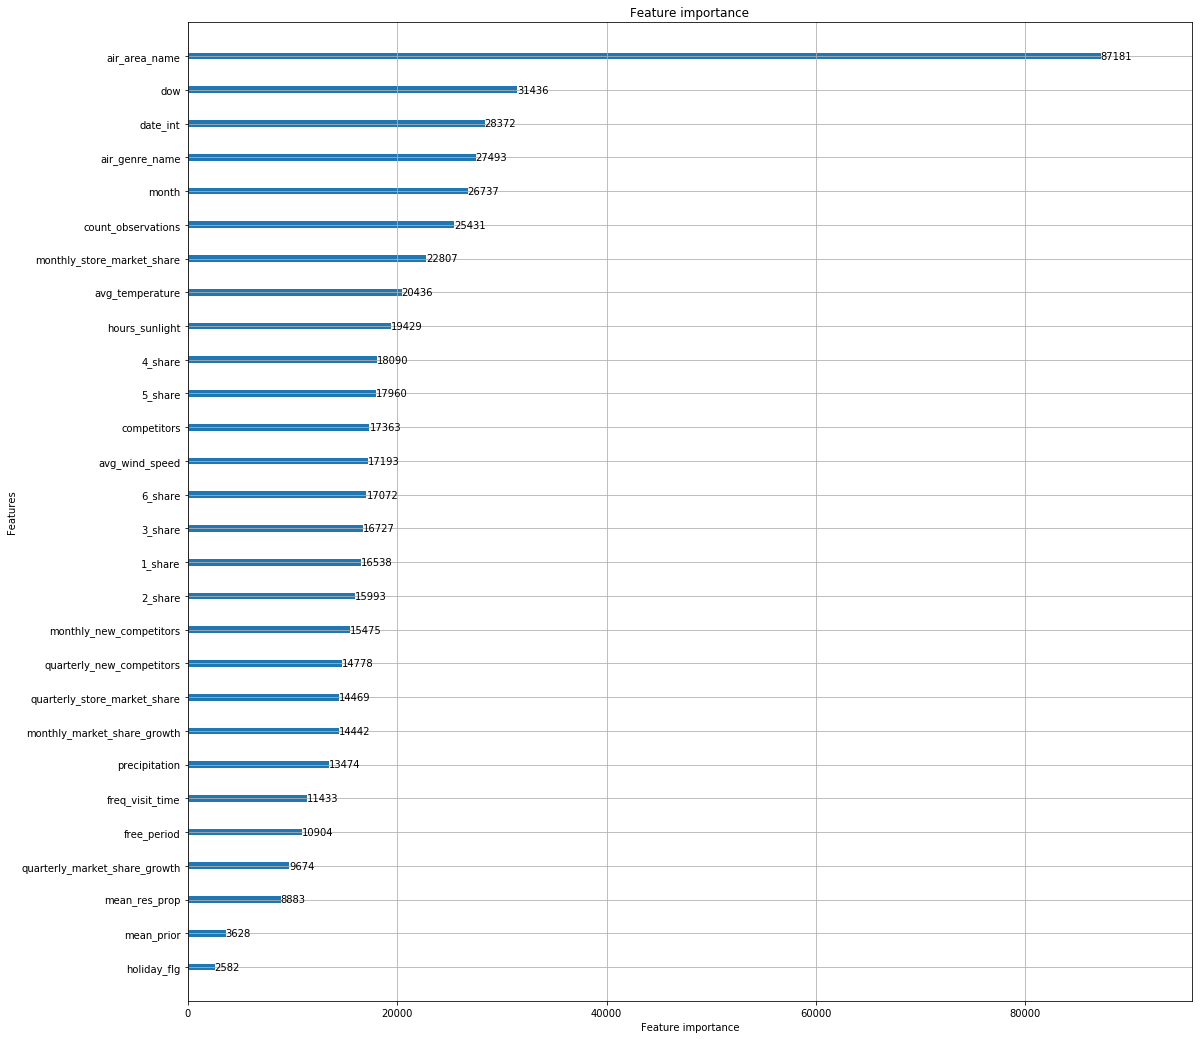

In [24]:
ax = lgb.plot_importance(gbm, max_num_features=34,figsize=(18,18))
plt.show()

In [25]:
df['test'][['id','visitors']].to_csv('new_submission_17.csv', index=False)